## Libraries

In [25]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(forecast)
library(Rssa)
library(TTR)
library(ggplot2)
options(repr.plot.width = 18, repr.plot.height = 8)

## Load the data

In [10]:
df1 <- read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 <- read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df <- rbind(df1, df2)
cat("The final database has ", nrow(df), " rows", "\n")

The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


In [11]:
df$time <- as.POSIXct(df$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [45]:
df_cleaned <- df[, c('time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'id','place','status') ]
head(df_cleaned)
sum(is.na(df_cleaned))

,time,latitude,longitude,depth,mag,magType,id,place,status
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,2025-06-24 03:04:54,41.4136,19.5656,10.000,4.2,mb,us7000q8c1,"7 km N of Shijak, Albania",reviewed
2,2025-06-21 14:56:54,38.0214,20.2244,53.184,4.2,mb,us6000qlmp,"27 km SW of Lixoúri, Greece",reviewed
3,2025-06-21 13:25:52,37.9115,20.1867,10.000,4.5,mb,us6000qlmf,"38 km SW of Lixoúri, Greece",reviewed
4,2025-06-01 16:44:09,43.1747,17.9562,10.000,4.0,mb,us6000qh9w,"8 km ENE of Crnići, Bosnia and Herzegovina",reviewed
5,2025-05-22 22:52:00,42.5041,18.3603,10.000,4.0,mb,us7000q0z4,"12 km WNW of Igalo, Montenegro",reviewed
6,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,us7000q0g6,"2 km NE of Besenello, Italy",reviewed


[1] 0

## EXERCISE. 

A time series is a series of data points
ordered and indexed in time. Most commonly, a time series is a sequence taken at successive equally
spaced points in time. It becomes clear that earthquake events do not fit very well with the definition of
a time series, since they are extremely irregular in time. Getting insipiration from the work of [5], define
two different time series: AEM (Average Earthquakes Magnitude) and MEM (Maximum Earthquakes
Magnitude) using a one year time step. Verify if with the two time series it is possible to predict future
trends of earthquakes in the same region. Perform a fit of the two time series using the ARIMA model
(AutoRegressive Integrated Moving Average).

## AEM and MEM

## Key aspects of time series analysis:  
## Data Collection:  
Time series data is collected at regular intervals, such as daily, monthly, or yearly.   
## Pattern Identification:  
The goal is to identify patterns like trends (long-term increase or decrease), seasonality (repeating patterns within a year), and cyclical patterns (longer-term fluctuations). 
## Forecasting:  
Based on identified patterns, time series analysis can be used to forecast future values of the data.  
## Modeling:    
Various statistical models, such as ARIMA (Autoregressive Integrated Moving Average), are used to represent the time series data and make predictions.  
## Applications:  
Time series analysis is widely used in various fields like economics, finance, marketing, and weather forecasting. 

In [59]:
# pick only years
df_cleaned$year <- year(df_cleaned$time)

# count the AEM and MEM
yearly_data <- df_cleaned %>%
  group_by(year) %>%
  summarise(
    AEM = mean(mag, na.rm = TRUE),
    MEM = max(mag, na.rm = TRUE)
  ) %>%
  arrange(year)

head(yearly_data)

year,AEM,MEM
<dbl>,<dbl>,<dbl>
1925,5.395000,5.75
1926,5.653333,5.93
1927,5.564286,6.02
1928,5.616000,5.98
1929,5.351000,5.53
1930,5.650000,6.64


## Calculate Descriptive Statistics for AEM and MEM

In [33]:
library(moments)  # for skewness and kurtosis
library(tseries)  # for ADF test

# AEM statistics
min_AEM <- min(yearly_data$AEM, na.rm = TRUE)
max_AEM <- max(yearly_data$AEM, na.rm = TRUE)
mean_AEM <- mean(yearly_data$AEM, na.rm = TRUE)
median_AEM <- median(yearly_data$AEM, na.rm = TRUE)
sd_AEM <- sd(yearly_data$AEM, na.rm = TRUE)
skew_AEM <- skewness(yearly_data$AEM, na.rm = TRUE)
kurt_AEM <- kurtosis(yearly_data$AEM, na.rm = TRUE)
adf_AEM <- adf.test(yearly_data$AEM)$p.value
shapiro_AEM <- shapiro.test(yearly_data$AEM)$p.value

# MEM statistics
min_MEM <- min(yearly_data$MEM, na.rm = TRUE)
max_MEM <- max(yearly_data$MEM, na.rm = TRUE)
mean_MEM <- mean(yearly_data$MEM, na.rm = TRUE)
median_MEM <- median(yearly_data$MEM, na.rm = TRUE)
sd_MEM <- sd(yearly_data$MEM, na.rm = TRUE)
skew_MEM <- skewness(yearly_data$MEM, na.rm = TRUE)
kurt_MEM <- kurtosis(yearly_data$MEM, na.rm = TRUE)
adf_MEM <- adf.test(yearly_data$MEM)$p.value
shapiro_MEM <- shapiro.test(yearly_data$MEM)$p.value

In [35]:
# Create summary table
stats_table <- data.frame(
  Statistic = c("Min", "Max", "Mean", "Median", "Standard Deviation", "Skewness", "Kurtosis", "ADF Test (P-Value)", "Shapiro-Wilk (P-Value)"),
  AEM = c(min_AEM, max_AEM, mean_AEM, median_AEM, sd_AEM, skew_AEM, kurt_AEM, adf_AEM, shapiro_AEM),
  MEM = c(min_MEM, max_MEM, mean_MEM, median_MEM, sd_MEM, skew_MEM, kurt_MEM, adf_MEM, shapiro_MEM)
)

stats_table

Statistic,AEM,MEM
<chr>,<dbl>,<dbl>
Min,2.952098e+00,5.100000000
Max,5.935000e+00,7.000000000
Mean,4.497841e+00,5.853673469
Median,4.359869e+00,5.775000000
Standard Deviation,9.901197e-01,0.448038998
Skewness,-2.216595e-01,0.622039146
Kurtosis,1.500605e+00,2.797719836
ADF Test (P-Value),7.674168e-01,0.017331259
Shapiro-Wilk (P-Value),8.530276e-08,0.001304293


In [62]:
nrow(yearly_data)
min(yearly_data$year)
max(yearly_data$year)

[1] 98

[1] 1925

[1] 2025

In [63]:
# Full sequence of expected years
full_years <- seq(min(yearly_data$year), max(yearly_data$year), by = 1)

# Identify missing years
missing_years <- setdiff(full_years, yearly_data$year)

# Show missing years
missing_years

[1] 1944 1961 1965

In [61]:
# creating Time Series 
AEM_ts <- ts(yearly_data$AEM, start = min(yearly_data$year), frequency = 1)
MEM_ts <- ts(yearly_data$MEM, start = min(yearly_data$year), frequency = 1)

# simple moving average each 5 years
AEM_SMA5 <- SMA(AEM_ts, n = 5)
MEM_SMA5 <- SMA(MEM_ts, n = 5)

#cat(AEM_SMA5)
str(AEM_ts)

 Time-Series [1:98] from 1925 to 2022: 5.39 5.65 5.56 5.62 5.35 ...


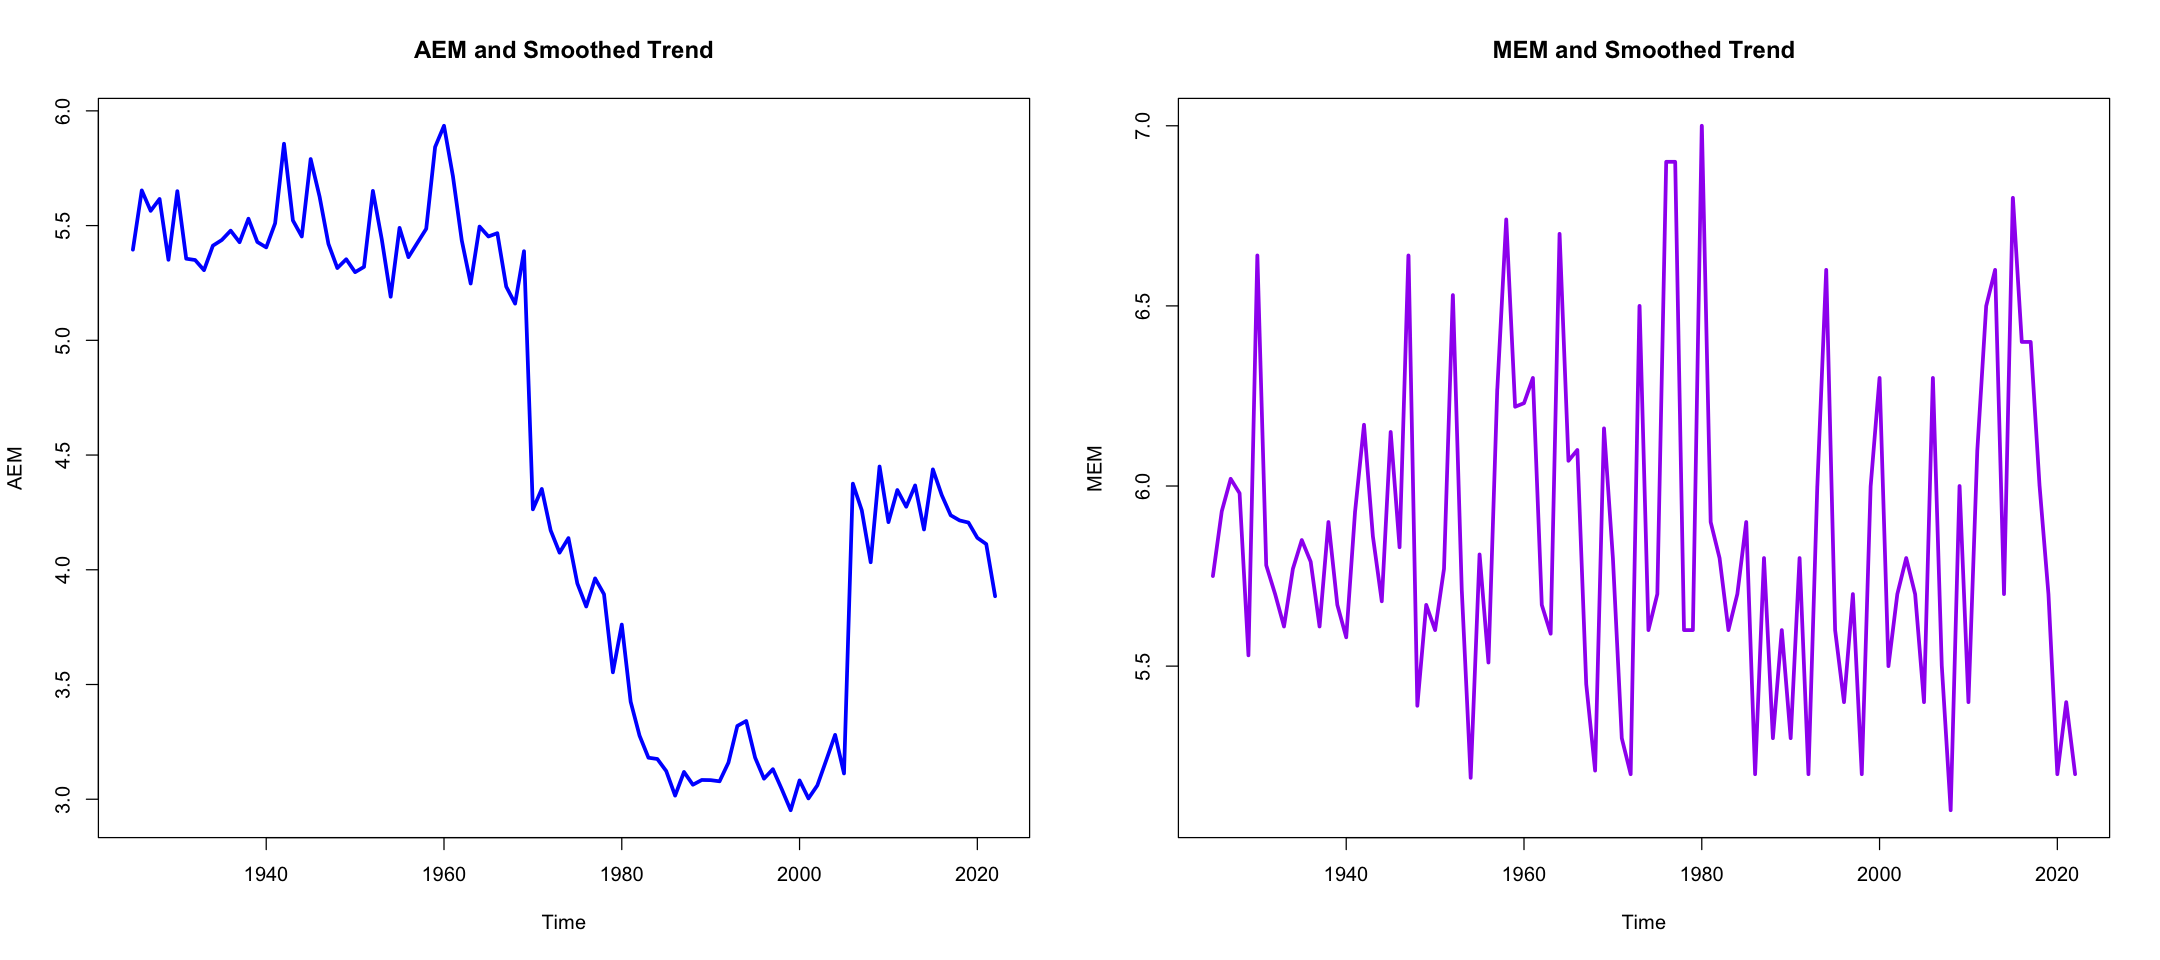

In [26]:
par(mfrow = c(1, 2))  # Two plots side by side
# Plot AEM with SMA
plot(AEM_ts, type = "l", col = "blue", main = "AEM and Smoothed Trend", ylab = "AEM", lwd = 3)
#lines(AEM_SMA5, col = "red",lwd = 3)
#legend("bottomleft", legend = c("AEM", "SMA 5 years"), col = c("blue", "red"), lty = 1, lwd = 3)

# Plot MEM with SMA
plot(MEM_ts, type = "l", col = "purple", main = "MEM and Smoothed Trend", ylab = "MEM", lwd = 3)
#lines(MEM_SMA5, col = "orange", lwd = 3)
#legend("bottomright", legend = c("MEM", "SMA 5 years"), col = c("purple", "orange"), lty = 1, lwd = 3)
par(mfrow = c(1, 1))

## ARIMA Model (autoregressive integrated moving average)

Non-seasonal ARIMA models are usually denoted ARIMA(p, d, q) where parameters p, d, q are non-negative integers: p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p, d, q)(P, D, Q)m, where the uppercase P, D, Q are the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model and m is the number of periods in each season.[8][2] When two of the parameters are 0, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym. For example, ⁠
ARIMA
(
1
,
0
,
0
)
{\displaystyle {\text{ARIMA}}(1,0,0)}⁠ is AR(1), ⁠
ARIMA
(
0
,
1
,
0
)
{\displaystyle {\text{ARIMA}}(0,1,0)}⁠ is I(1), and ⁠
ARIMA
(
0
,
0
,
1
)
{\displaystyle {\text{ARIMA}}(0,0,1)}⁠ is MA(1).  

Some well-known special cases arise naturally or are mathematically equivalent to other popular forecasting models. For example:  
ARIMA(0, 0, 0) models white noise.  
An ARIMA(0, 1, 0) model is a random walk.  
An ARIMA(0, 1, 2) model is a Damped Holt's model.  
An ARIMA(0, 1, 1) model without constant is a basic exponential smoothing model.[9]

In [18]:
# Fit ARIMA model for AEM
model_AEM <- auto.arima(AEM_ts)
summary(model_AEM)

Series: AEM_ts 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.2607
s.e.   0.0985

sigma^2 = 0.05443:  log likelihood = 4
AIC=-4.01   AICc=-3.88   BIC=1.14

Training set error measures:
                      ME      RMSE      MAE        MPE     MAPE     MASE
Training set -0.01886117 0.2309128 0.151895 -0.5779858 3.428184 0.959687
                    ACF1
Training set -0.02505676

In [19]:
# Fit ARIMA model for MEM
model_MEM <- auto.arima(MEM_ts)
summary(model_MEM)

Series: MEM_ts 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      5.8537
s.e.  0.0450

sigma^2 = 0.2007:  log likelihood = -59.87
AIC=123.74   AICc=123.87   BIC=128.91

Training set error measures:
                        ME      RMSE      MAE        MPE     MAPE      MASE
Training set -1.499141e-14 0.4457472 0.354015 -0.5610463 5.991055 0.7670193
                  ACF1
Training set 0.1367273

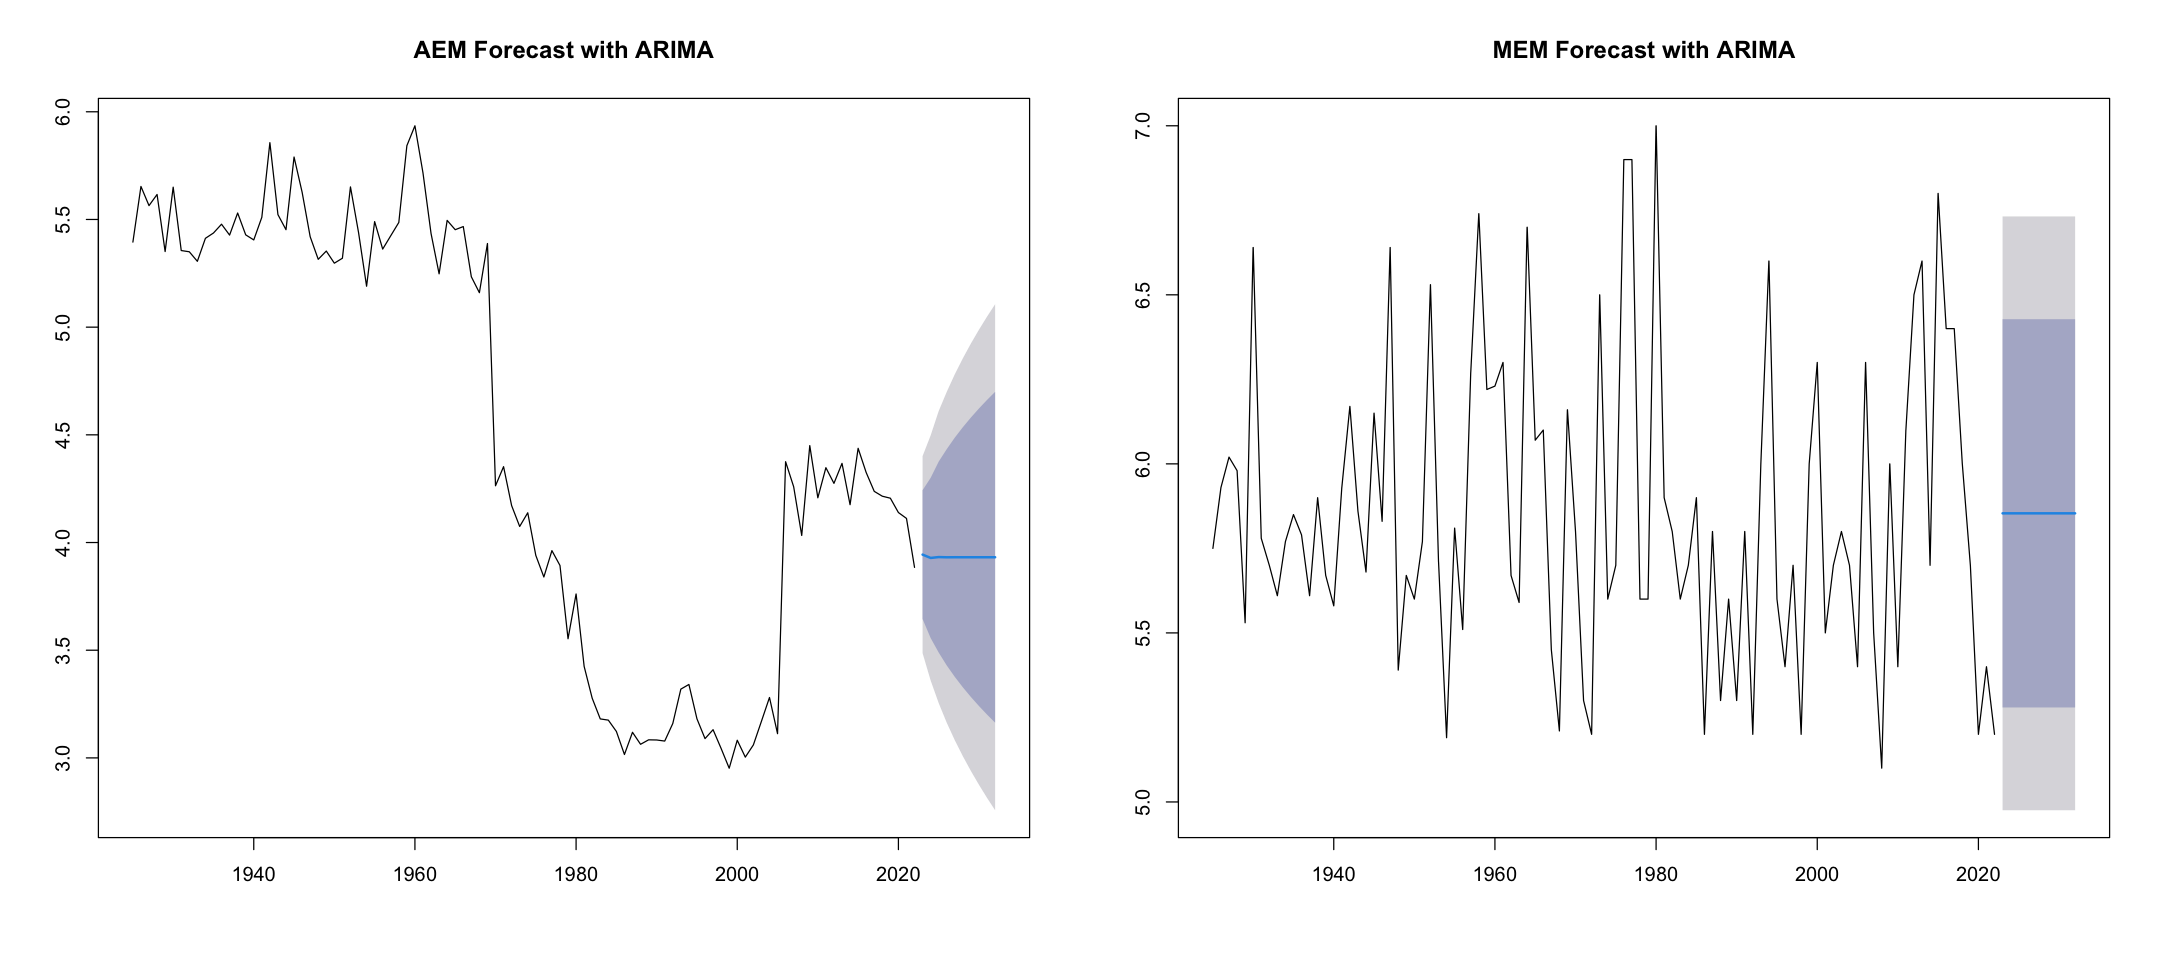

In [29]:
# Forecast next 10 years
forecast_AEM <- forecast(model_AEM, h = 10)
# Forecast next 10 years
forecast_MEM <- forecast(model_MEM, h = 10)


par(mfrow = c(1, 2))  # Two plots side by side
# Plot forecast
plot(forecast_AEM, main = "AEM Forecast with ARIMA")
# Plot forecast
plot(forecast_MEM, main = "MEM Forecast with ARIMA")
# Reset to default
par(mfrow = c(1, 1))


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)
Q* = 8.0661, df = 9, p-value = 0.5275

Model df: 1.   Total lags used: 10



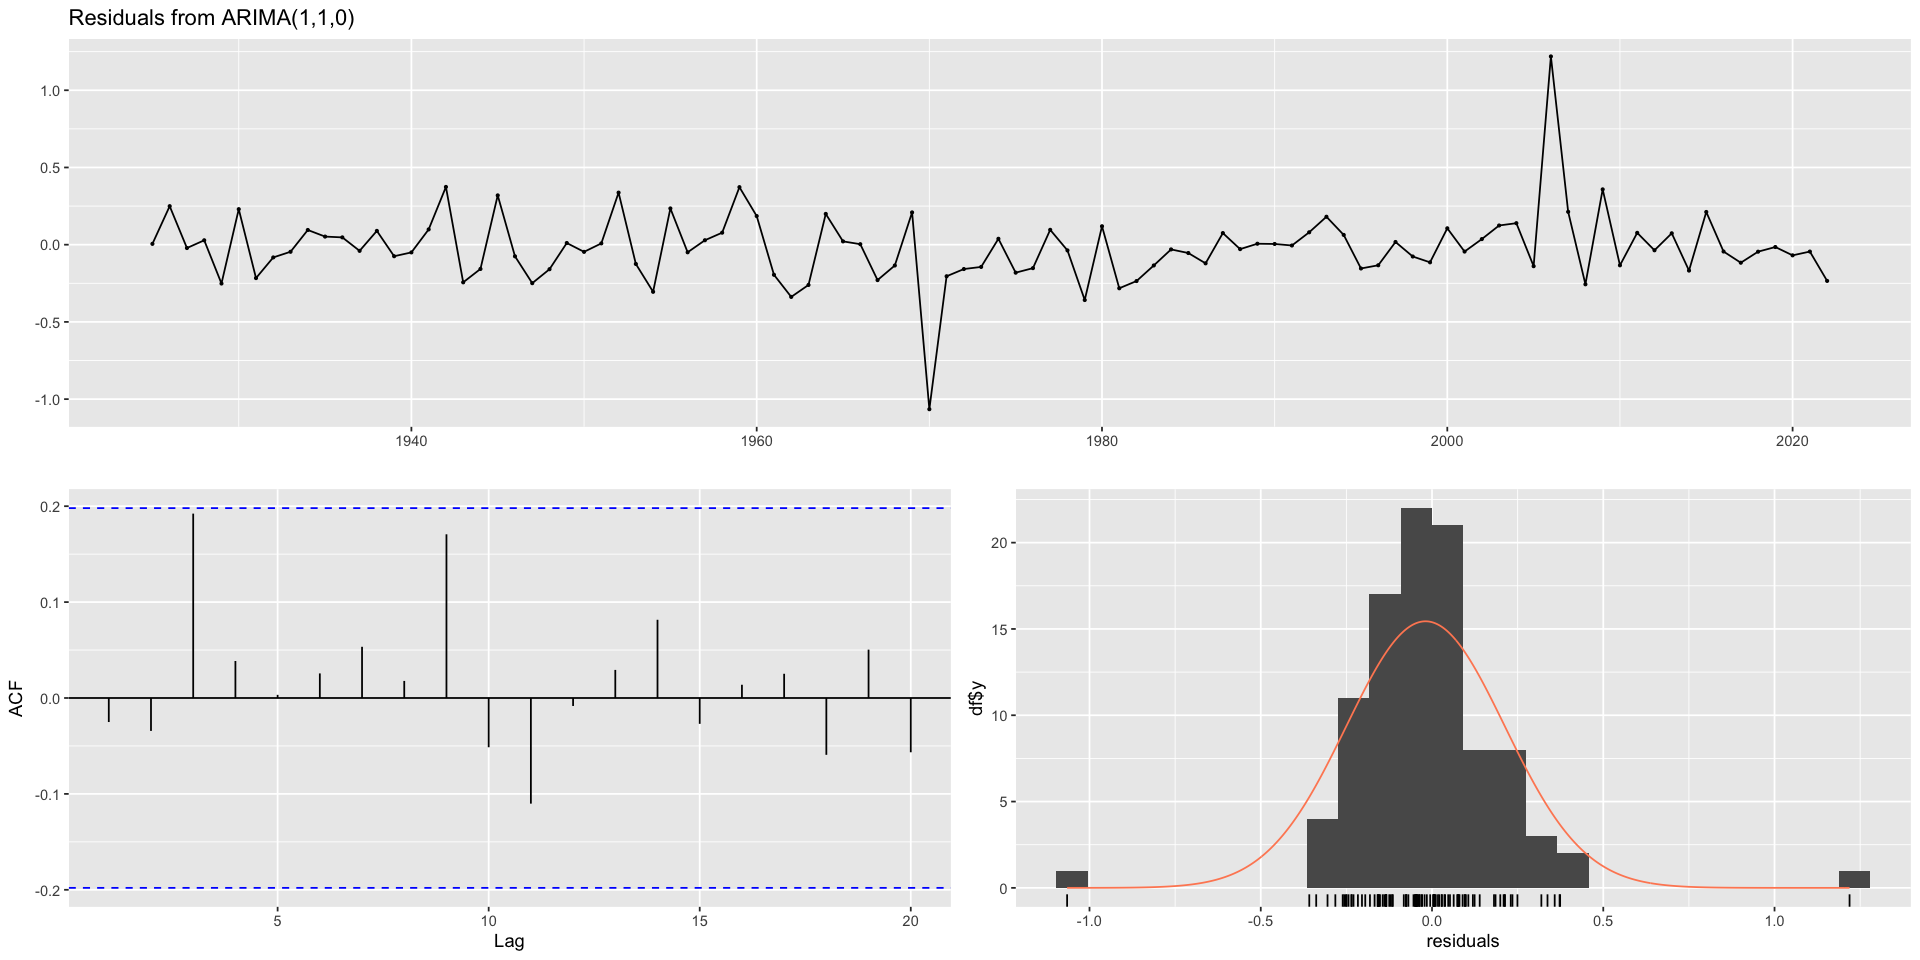


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0) with non-zero mean
Q* = 18.869, df = 10, p-value = 0.04196

Model df: 0.   Total lags used: 10



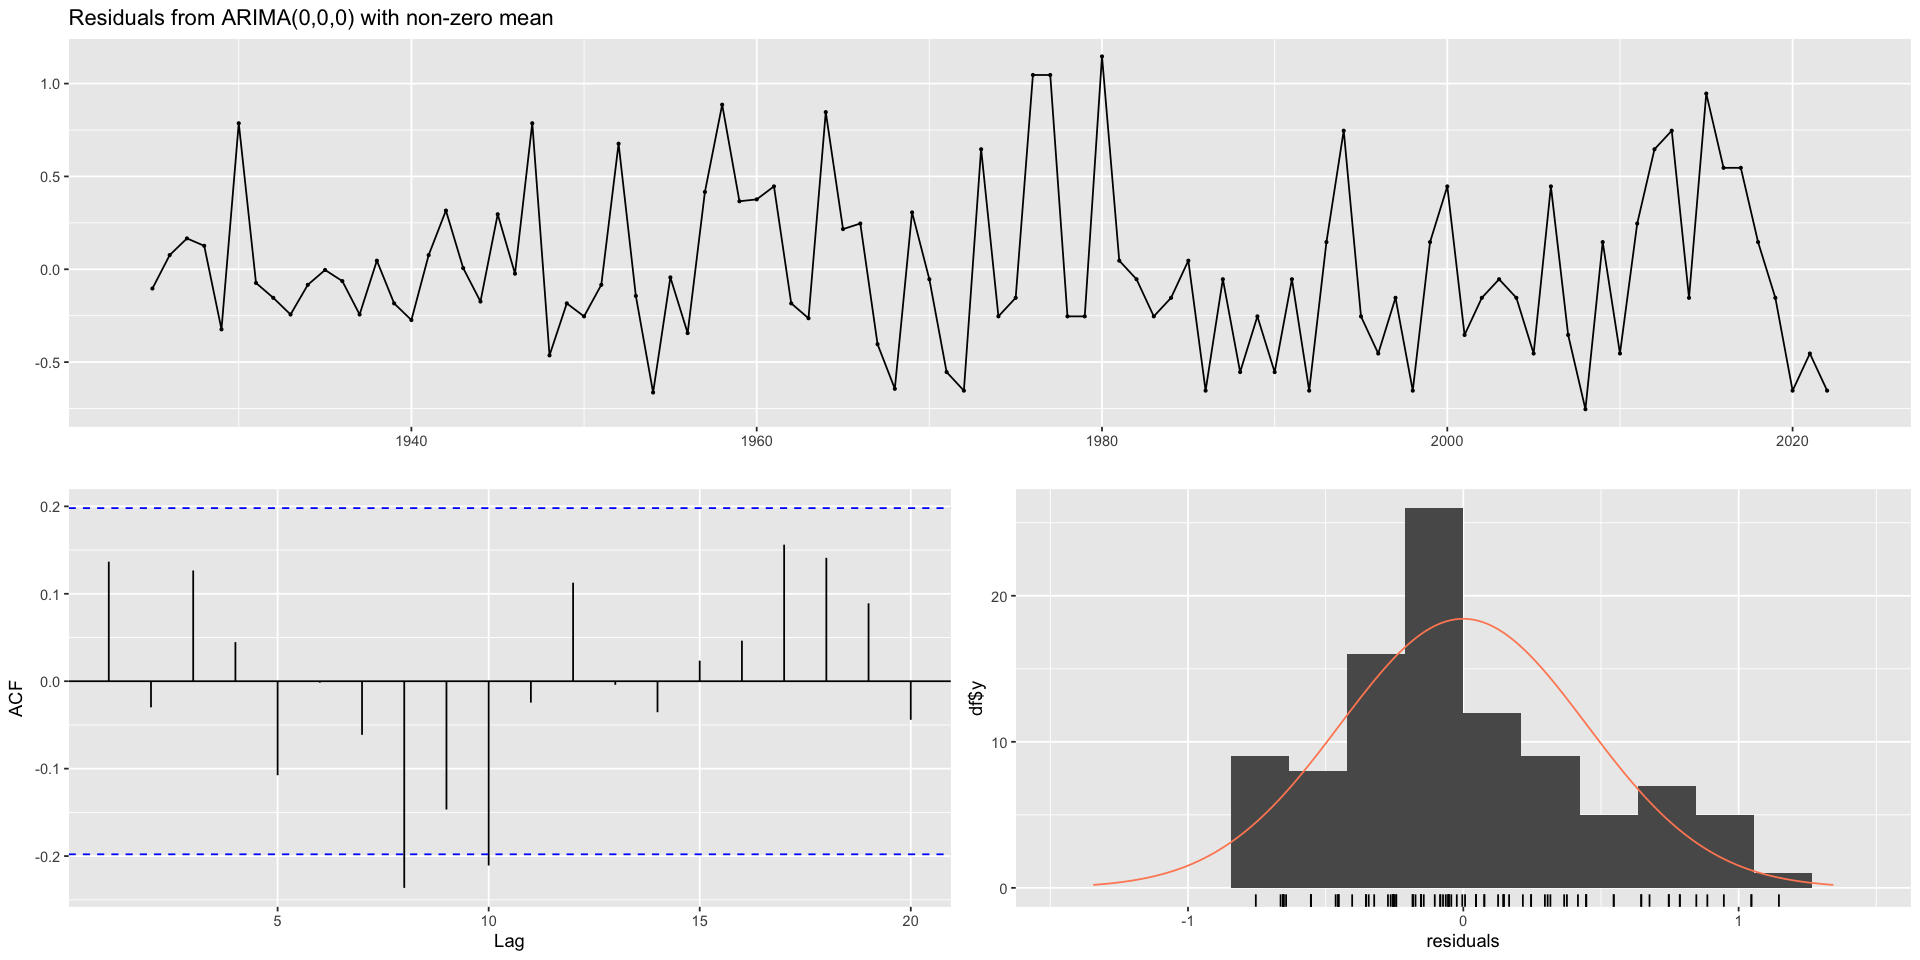

In [21]:
checkresiduals(model_AEM)

# MEM Residuals check
checkresiduals(model_MEM)


## SSA Model

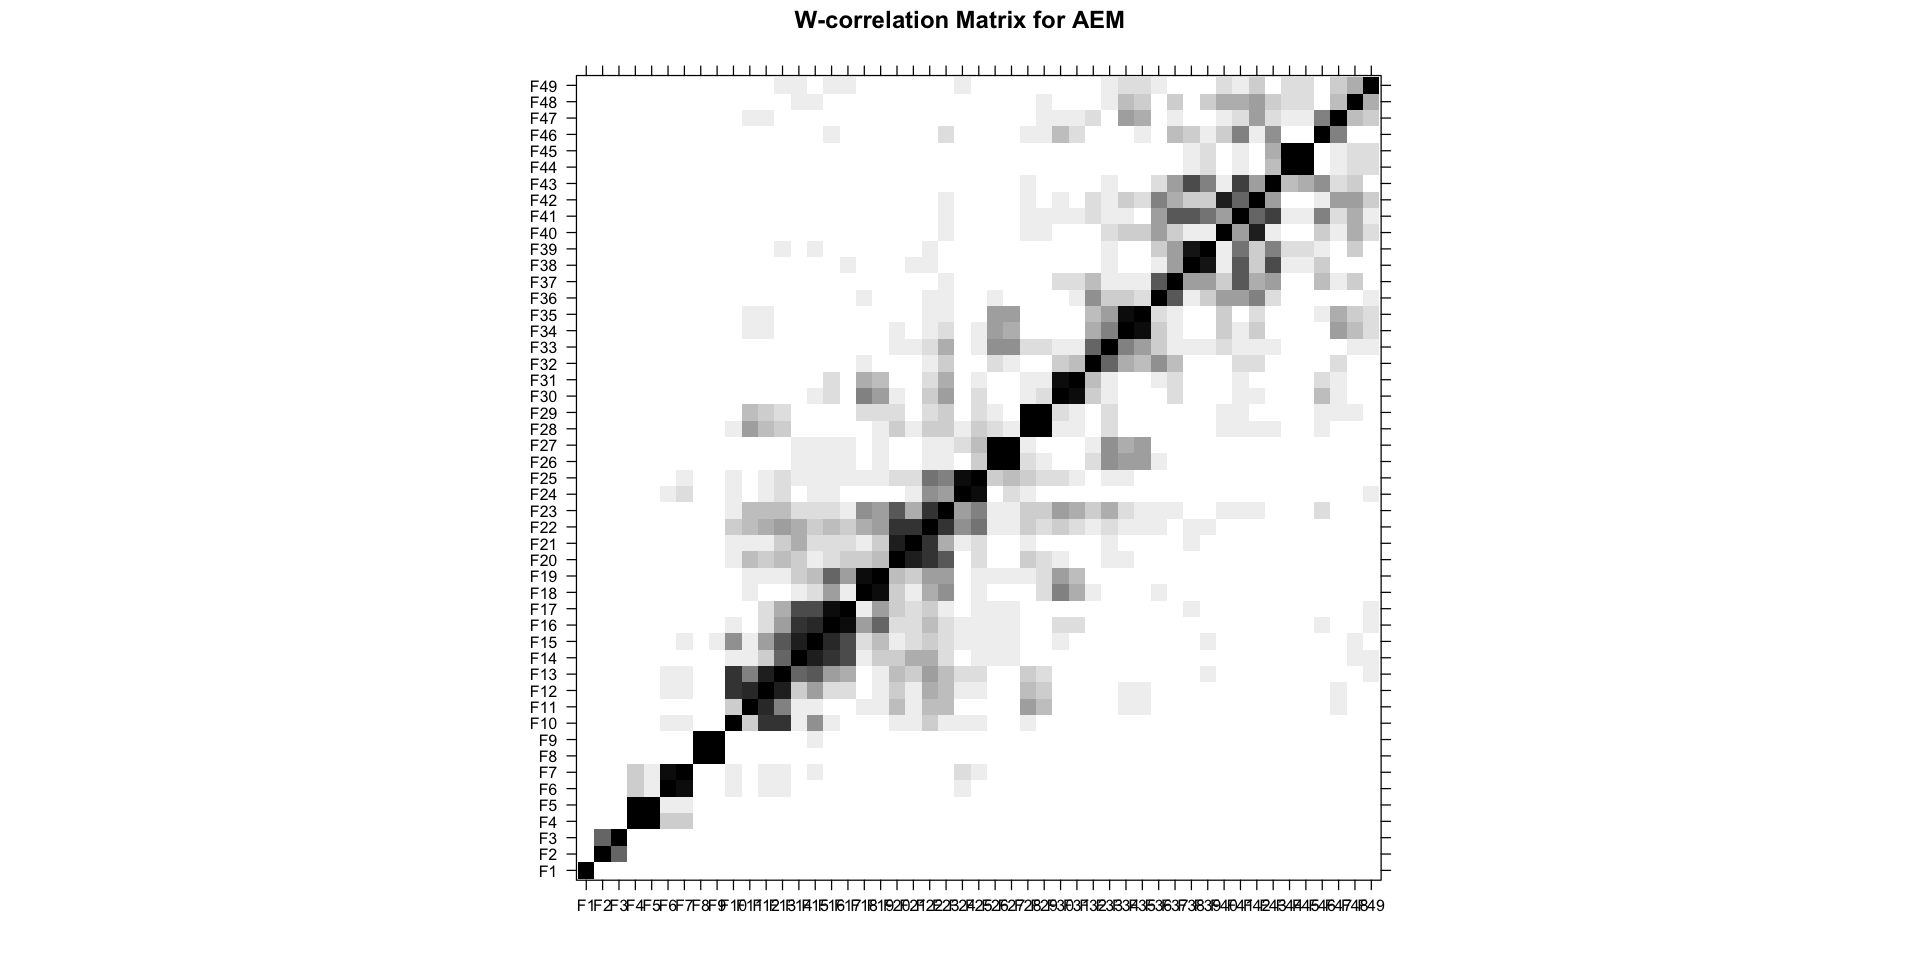

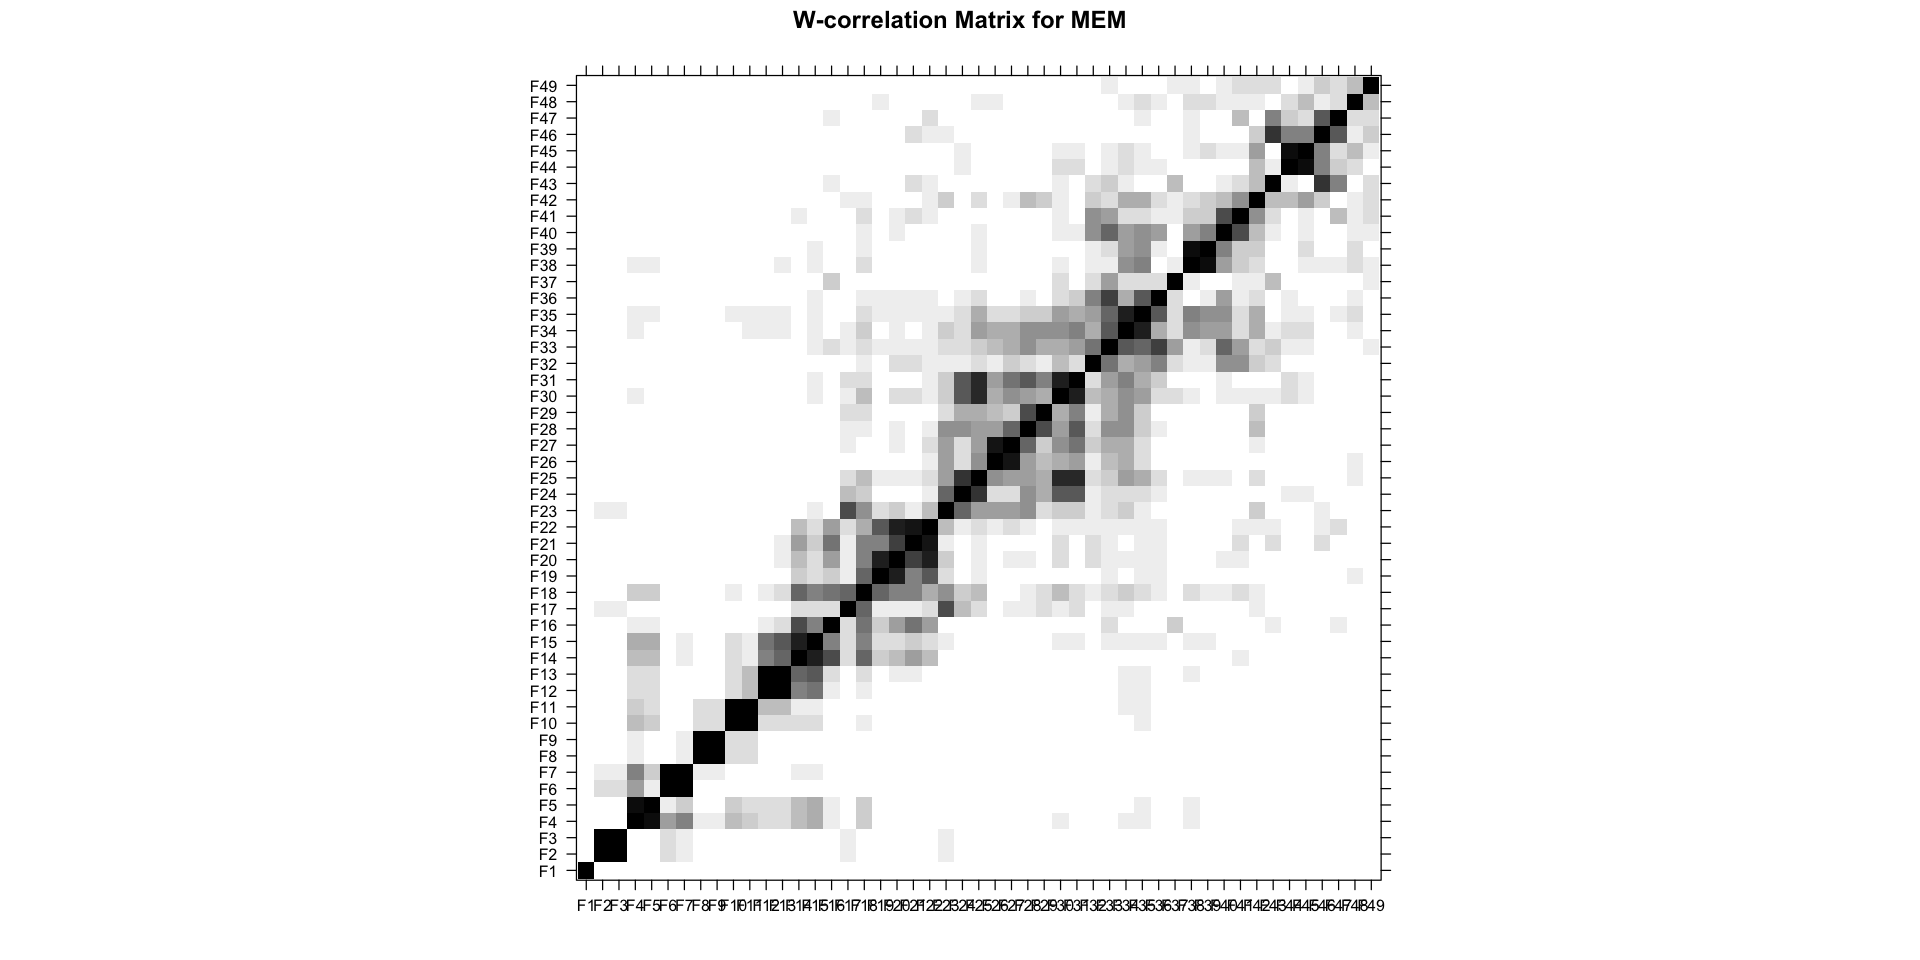

In [22]:
# Apply SSA to the AEM time series
ssa_AEM <- ssa(AEM_ts)
# Apply SSA to the MEM time series
ssa_MEM <- ssa(MEM_ts)

# Side by side plots
par(mfrow = c(1, 2))

# W-correlation Matrix for AEM
plot(wcor(ssa_AEM), main = "W-correlation Matrix for AEM")

# W-correlation Matrix for MEM
plot(wcor(ssa_MEM), main = "W-correlation Matrix for MEM")

# Reset layout
par(mfrow = c(1, 1))




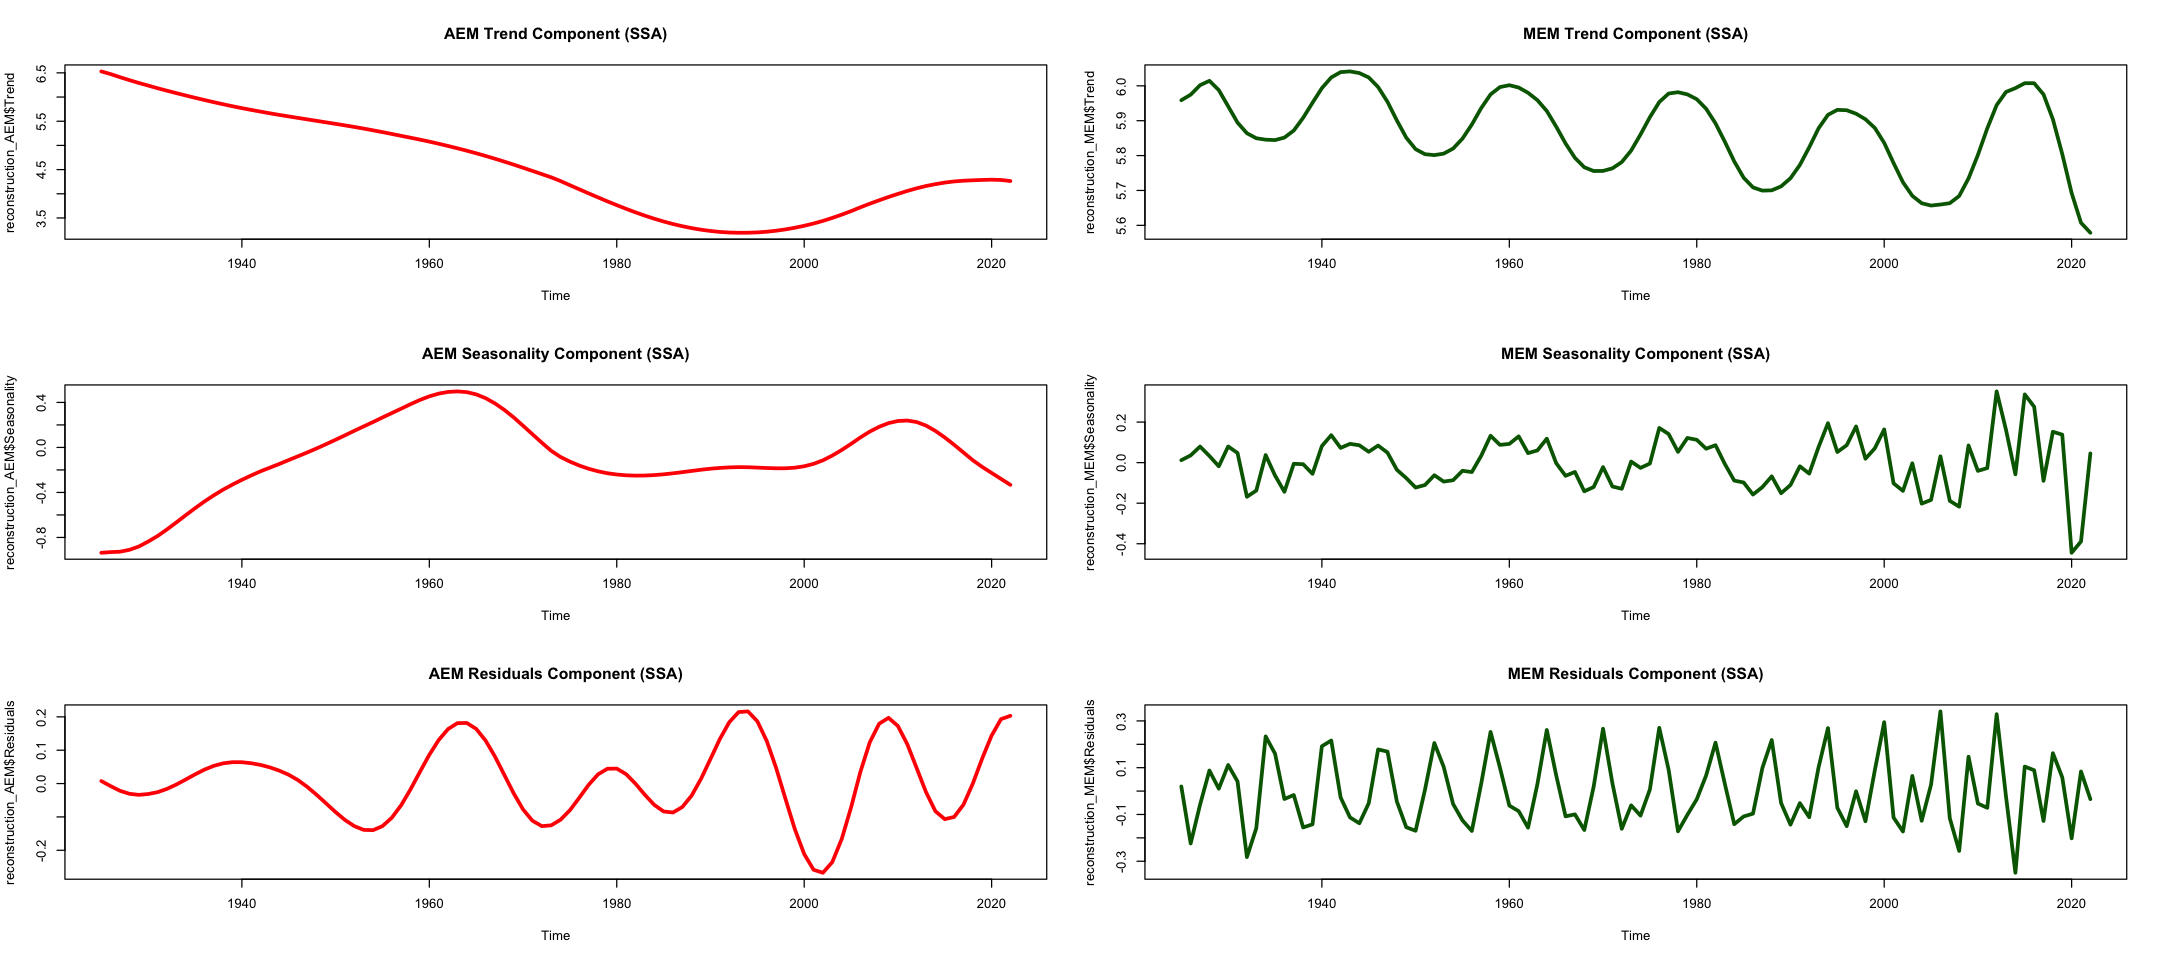

In [28]:
# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_AEM <- reconstruct(ssa_AEM, groups = list(Trend = 1:2, Seasonality = 3:4, Residuals = 5:length(ssa_AEM)))
# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_MEM <- reconstruct(ssa_MEM, groups = list(Trend = 1:2, Seasonality = 3:4, Residuals = 5:length(ssa_MEM)))

# Side by side plots
par(mfrow = c(3, 2))
plot(reconstruction_AEM$Trend, type = "l", col = "red", main = "AEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Trend, type = "l", col = "darkgreen", main = "MEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_AEM$Seasonality, type = "l", col = "red", main = "AEM Seasonality Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Seasonality, type = "l", col = "darkgreen", main = "MEM Seasonality Component (SSA)", lwd = 3)
plot(reconstruction_AEM$Residuals, type = "l", col = "red", main = "AEM Residuals Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Residuals, type = "l", col = "darkgreen", main = "MEM Residuals Component (SSA)", lwd = 3)
par(mfrow = c(1,1))


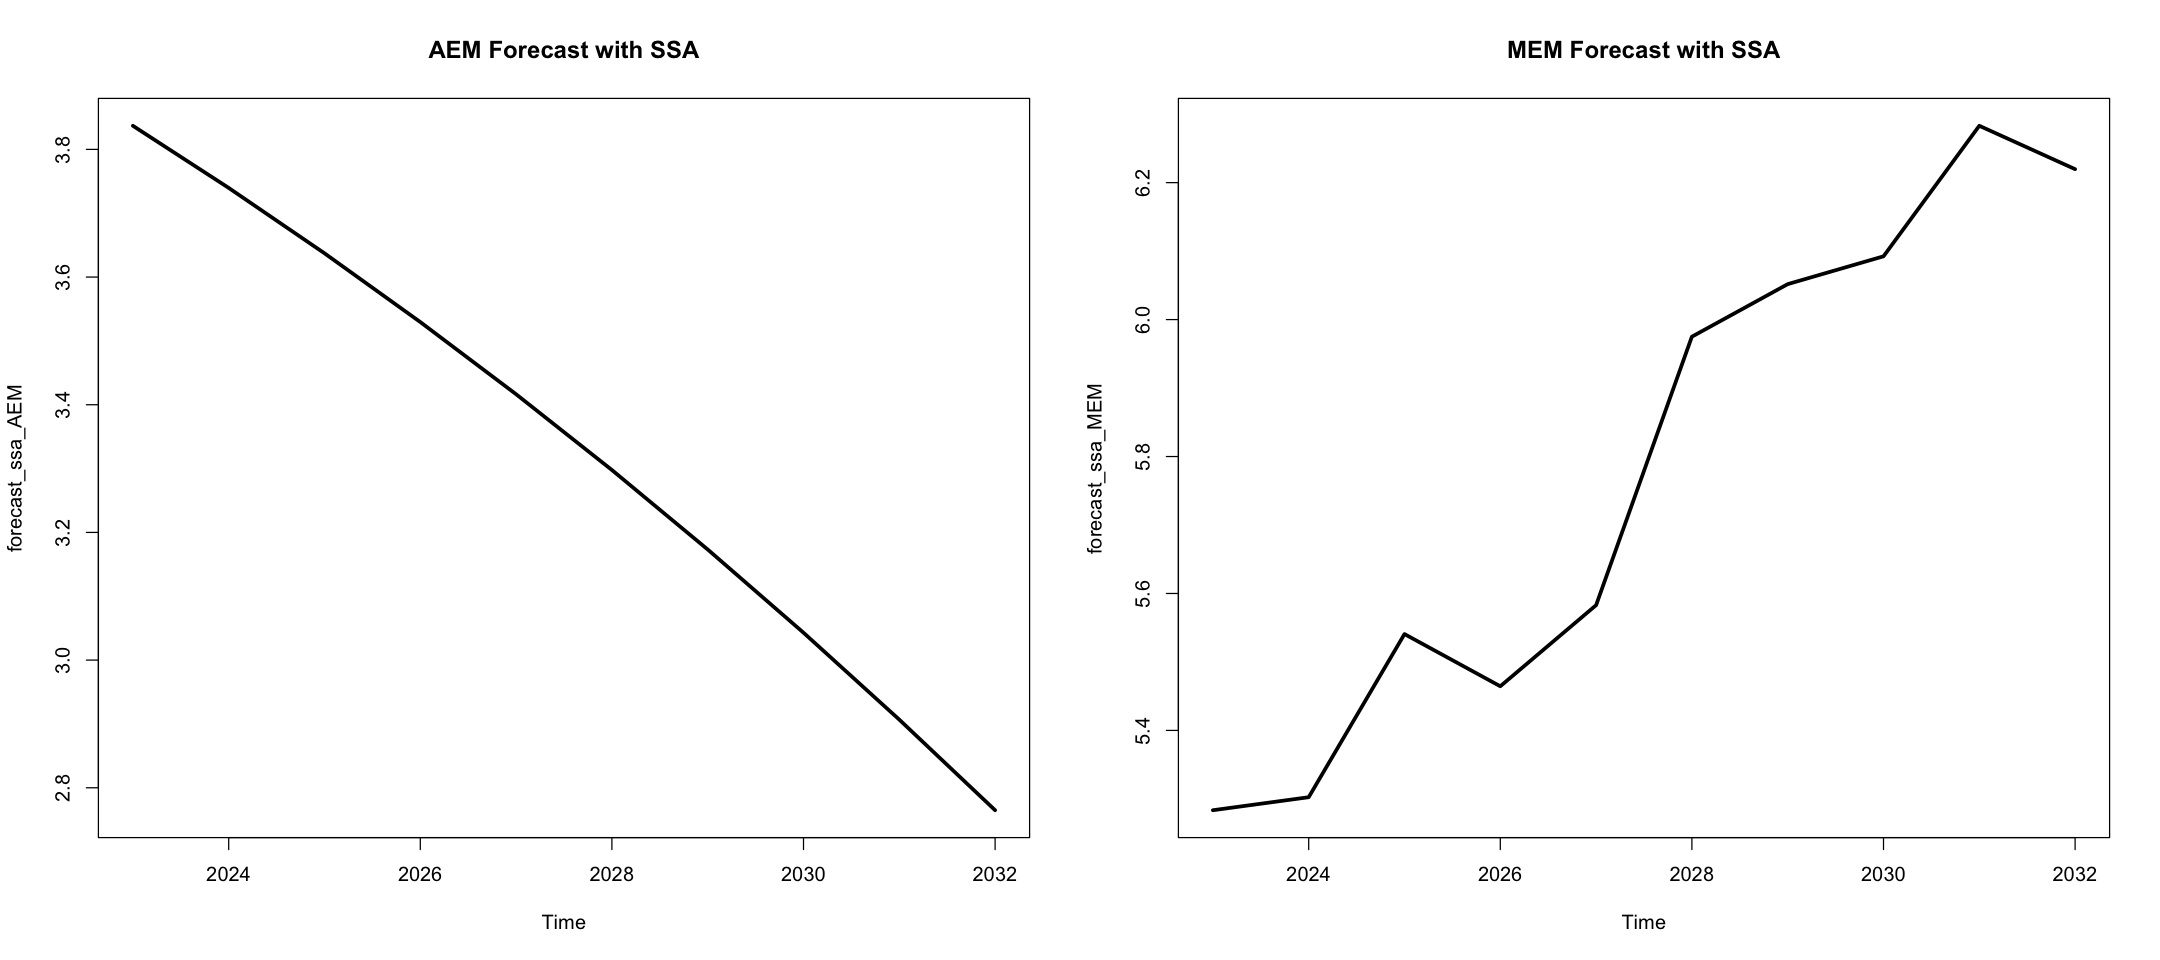

In [51]:
# Forecast next 10 years using SSA
forecast_ssa_AEM <- rforecast(ssa_AEM, groups = list(1:4), len = 10)
# Forecast for MEM
forecast_ssa_MEM <- rforecast(ssa_MEM, groups = list(1:4), len = 10)
# Plot the forecast
par(mfrow = c(1, 2))
plot(forecast_ssa_AEM, main = "AEM Forecast with SSA", lwd = 3)
plot(forecast_ssa_MEM, main = "MEM Forecast with SSA" , lwd = 3)
par(mfrow = c(1,1))


## RMSE (root mean square error )

RMSE Formula

For n data points:

$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }$

Where:
	•	$y_i$ = actual observed value. 
	•	$\hat{y}_i$ = predicted value

Lower RMSE = Better model fit, assuming residuals behave like white noise.

In [37]:
# AEM RMSE for ARIMA
actual_AEM <- AEM_ts
fitted_AEM <- fitted(model_AEM)
rmse_AEM_arima <- sqrt(mean((actual_AEM - fitted_AEM)^2, na.rm = TRUE))

# MEM RMSE for ARIMA
actual_MEM <- MEM_ts
fitted_MEM <- fitted(model_MEM)
rmse_MEM_arima <- sqrt(mean((actual_MEM - fitted_MEM)^2, na.rm = TRUE))

# SSA RMSE for AEM
recon_AEM <- reconstruction_AEM$Trend + reconstruction_AEM$Seasonality
rmse_AEM_ssa <- sqrt(mean((AEM_ts - recon_AEM)^2, na.rm = TRUE))

# SSA RMSE for MEM
recon_MEM <- reconstruction_MEM$Trend + reconstruction_MEM$Seasonality
rmse_MEM_ssa <- sqrt(mean((MEM_ts - recon_MEM)^2, na.rm = TRUE))

In [38]:
# RMSE summary table
rmse_table <- data.frame(
  Method = c("ARIMA", "SSA"),
  AEM_RMSE = c(rmse_AEM_arima, rmse_AEM_ssa),
  MEM_RMSE = c(rmse_MEM_arima, rmse_MEM_ssa)
)
rmse_table

Method,AEM_RMSE,MEM_RMSE
<chr>,<dbl>,<dbl>
ARIMA,0.2309128,0.4457472
SSA,0.1909091,0.3622676


## Table forecast AEM and MEM for the next 10 years

In [49]:
# SSA forecast for AEM
# Forecast next 11 years for AEM
forecast_ssa_AEM <- rforecast(ssa_AEM, groups = list(1:4), len = 11)

# The forecast itself is a vector
forecast_values_AEM <- forecast_ssa_AEM
# SSA forecast for MEM

forecast_ssa_MEM <- rforecast(ssa_MEM, groups = list(1:4), len = 11)
forecast_values_MEM <- forecast_ssa_MEM

In [50]:
# Forecast year range
forecast_years <- seq(max(yearly_data$year) + 1, max(yearly_data$year) + 11)

# Data frame with rounded results
forecast_table <- data.frame(
  Year = forecast_years,
  AEM_Mw = round(forecast_values_AEM, 3),
  MEM_Mw = round(forecast_values_MEM, 3)
)

# Print table
print(forecast_table)

   Year AEM_Mw MEM_Mw
1  2026  3.837  5.283
2  2027  3.740  5.302
3  2028  3.637  5.541
4  2029  3.530  5.464
5  2030  3.416  5.583
6  2031  3.298  5.975
7  2032  3.173  6.052
8  2033  3.043  6.092
9  2034  2.907  6.283
10 2035  2.765  6.220
11 2036  2.618  6.132


In [52]:
# Combine historical AEM with forecast
AEM_full <- c(AEM_ts, forecast_values_AEM)

# Combine historical MEM with forecast
MEM_full <- c(MEM_ts, forecast_values_MEM)

# Create extended time axis
years_full <- seq(min(yearly_data$year), max(yearly_data$year) + 11)

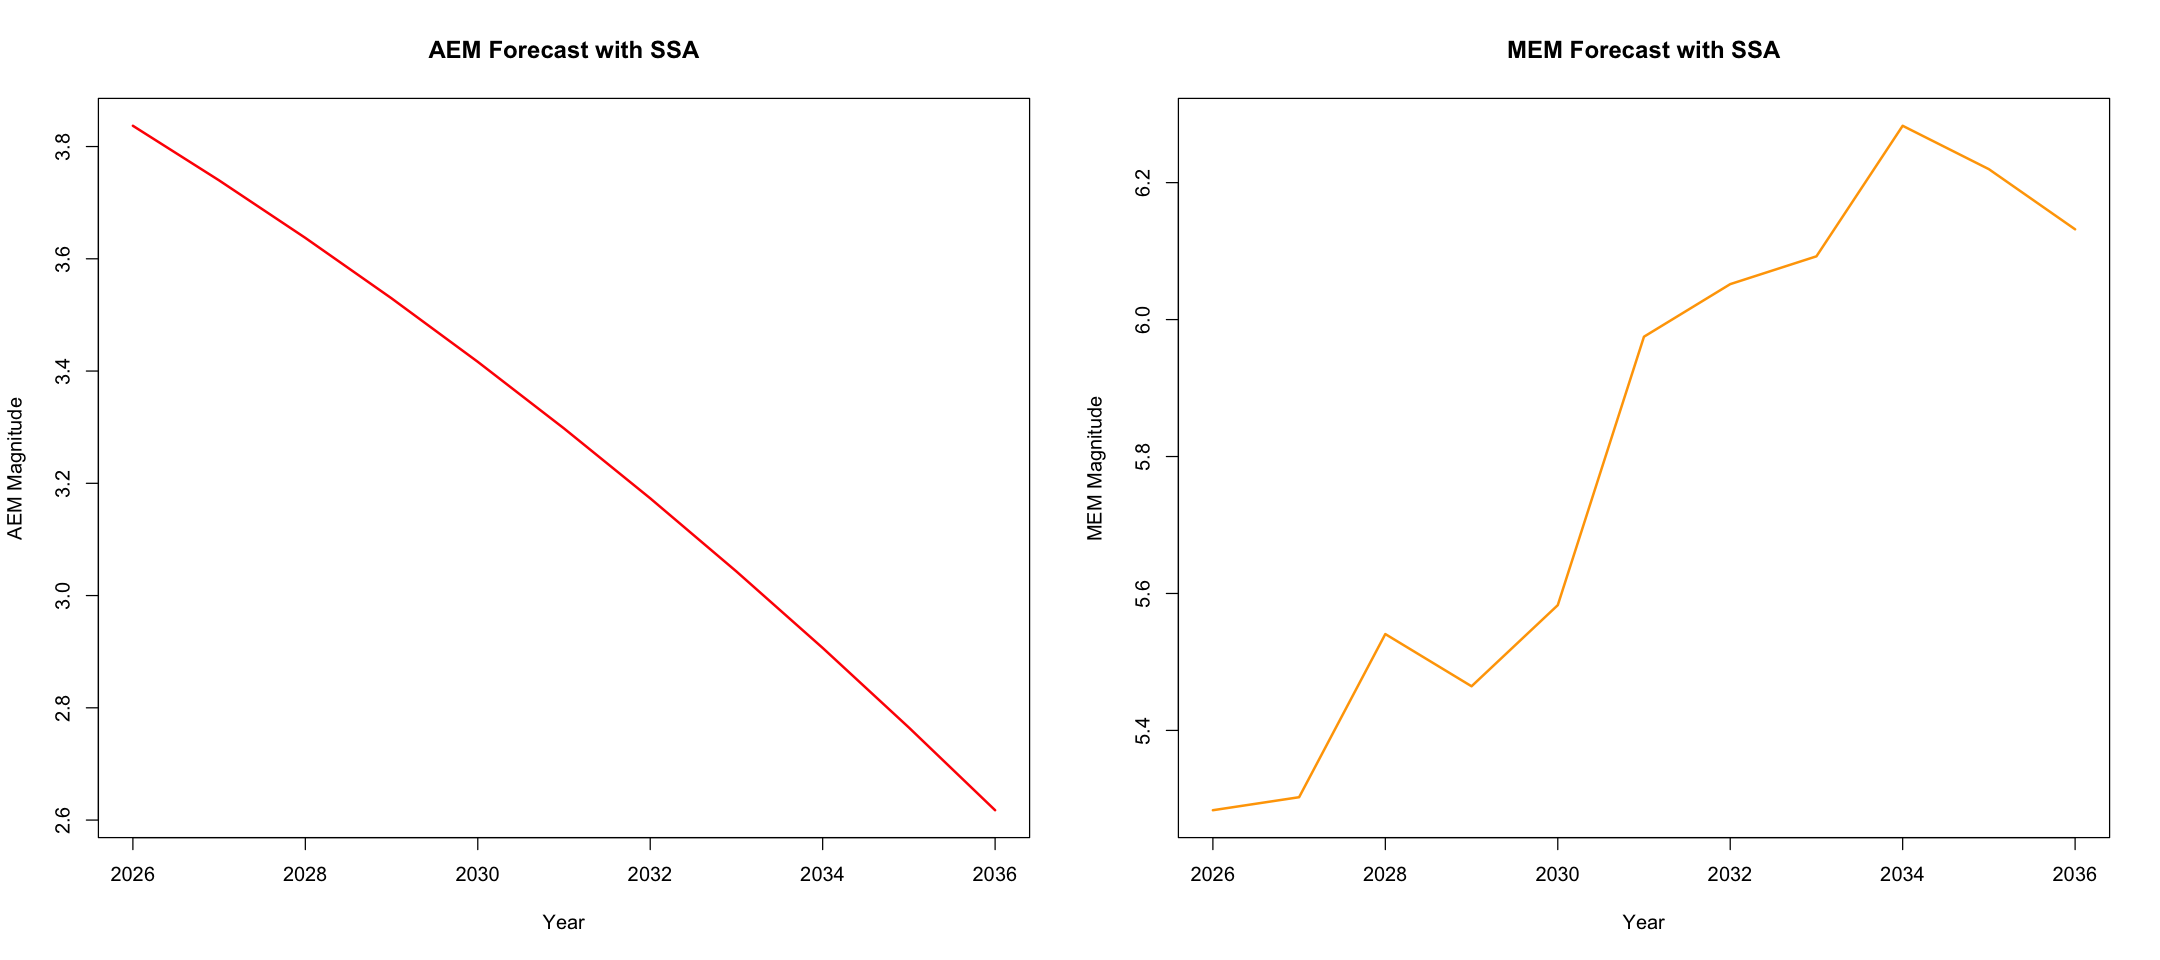

In [55]:
par(mfrow = c(1, 2))

# AEM forecast only
plot(forecast_years, forecast_values_AEM, type = "l", col = "red", lwd = 2,
     main = "AEM Forecast with SSA", xlab = "Year", ylab = "AEM Magnitude")

# MEM forecast only
plot(forecast_years, forecast_values_MEM, type = "l", col = "orange", lwd = 2,
     main = "MEM Forecast with SSA", xlab = "Year", ylab = "MEM Magnitude")

par(mfrow = c(1, 1))

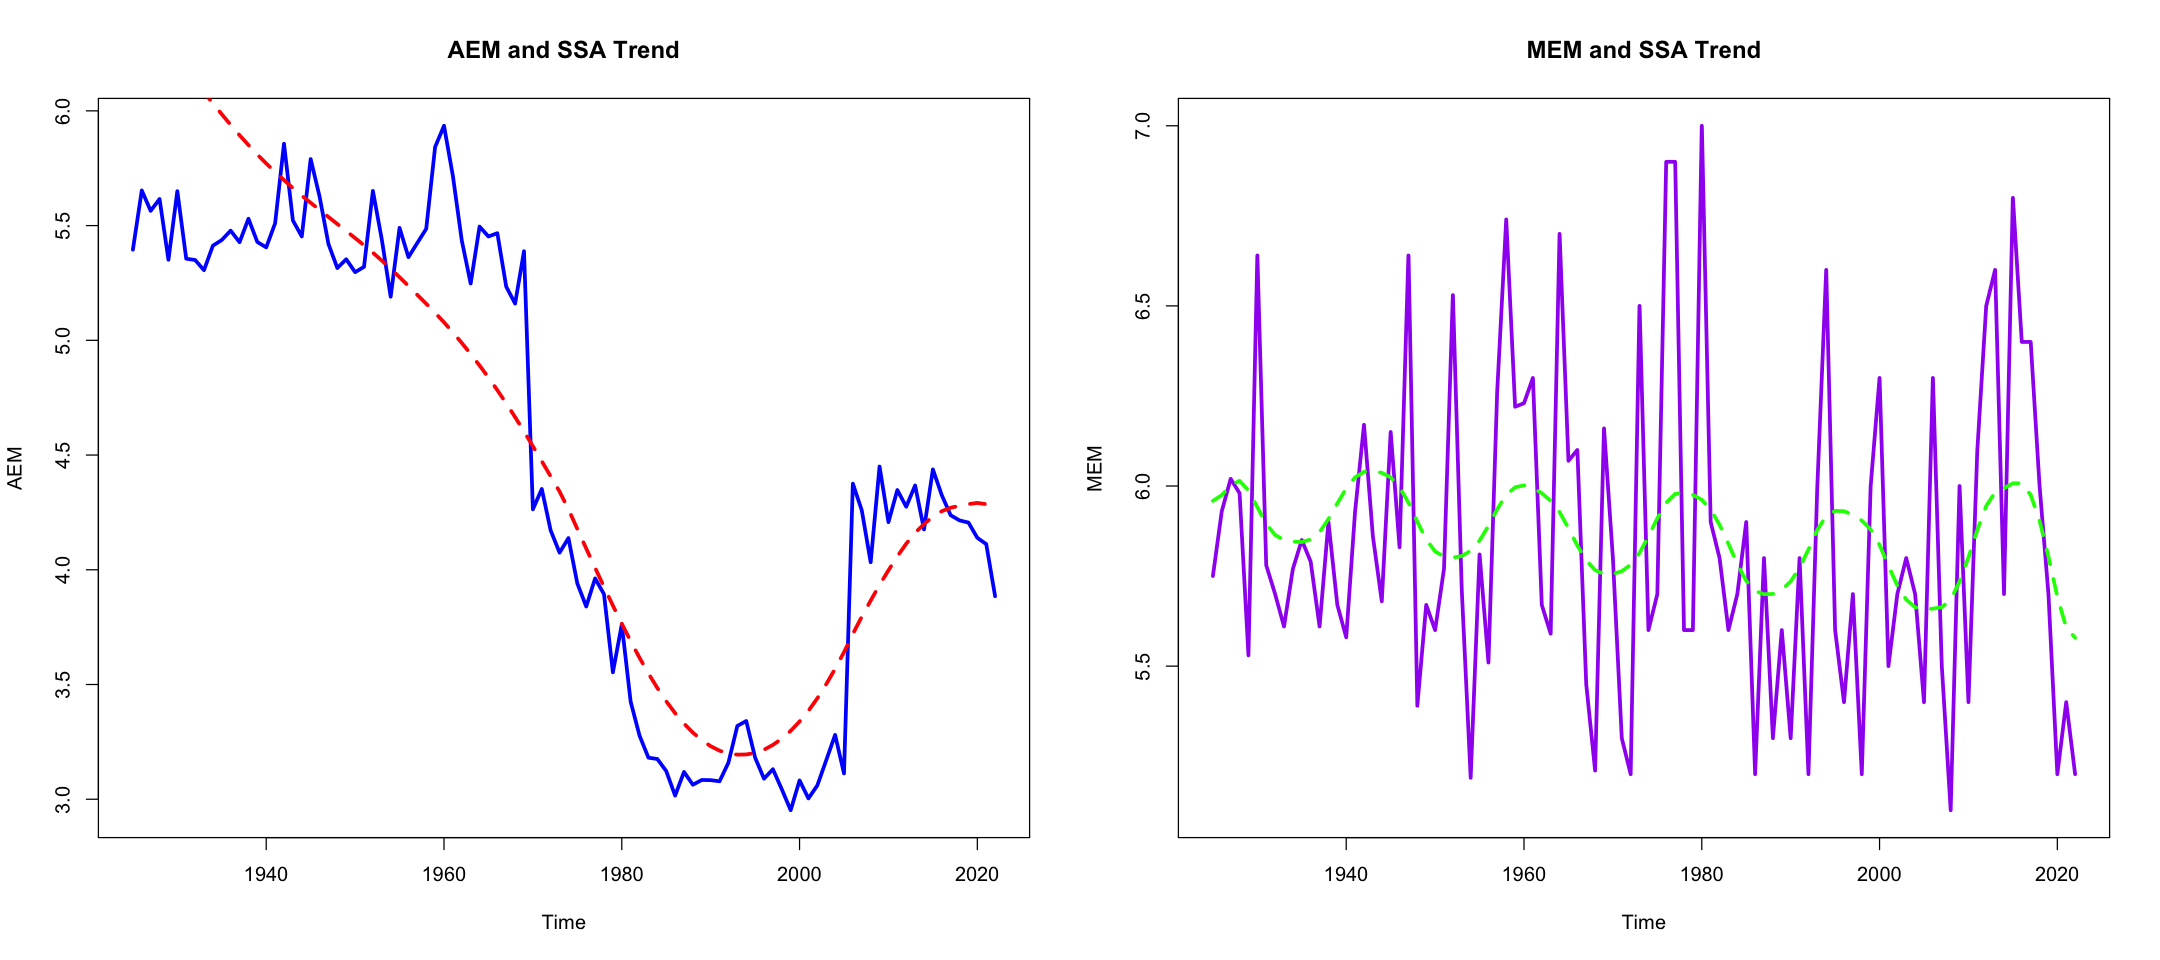

In [69]:
par(mfrow = c(1,2))


plot(AEM_ts, type = "l", col = "blue", main = "AEM and SSA Trend", ylab = "AEM", lwd = 3)
lines(reconstruction_AEM$Trend, type = "l", col = "red", main = "AEM Trend Component (SSA)", lwd = 3, lty = 2)

plot(MEM_ts, type = "l", col = "purple", main = "MEM and SSA Trend", ylab = "MEM", lwd = 3)
lines(reconstruction_MEM$Trend, type = "l", col = "green", main = "MEM Trend Component (SSA)", lwd = 3, lty = 2)

par(mfrow = c(1,1))